# Считывание и подготовка данных

In [96]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [97]:
df = pd.read_csv('cardataset/data.csv')

In [98]:
len(df)

11914

In [99]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


Переводит все имена столбцов в нижний регистр и заменяет пробелы символами подчеркивания

In [100]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

Выбирает только столбцы со строковыми значениями

In [101]:
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

Понижает регистр и заменяет пробелы символами подчеркивания дял значений во всех строковых столбцах датафрейма

In [102]:
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

# Анализ целевых переменных

<Axes: xlabel='msrp', ylabel='Count'>

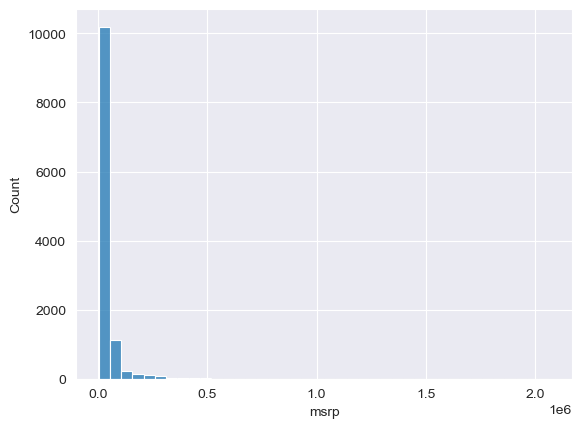

In [103]:
sns.histplot(df.msrp, bins=40)

<Axes: xlabel='msrp', ylabel='Count'>

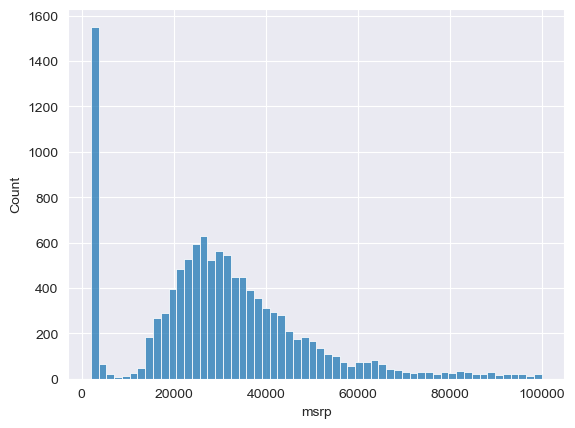

In [104]:
sns.histplot(df.msrp[df.msrp < 100000])

<Axes: xlabel='msrp', ylabel='Count'>

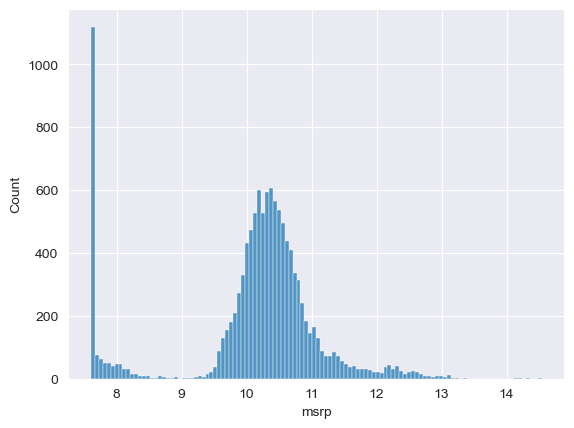

In [105]:
log_price = np.log1p(df.msrp)
sns.histplot(log_price)

# Проверка на наличие пропущенных значений

In [106]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

# Разделение данных на наборы для проверки, тестирования и обучения

In [107]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled[:n_train].copy()
df_val = df_shuffled[n_train:n_train + n_val].copy()
df_test = df_shuffled[n_train + n_val:].copy()

In [108]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

# Обучающая модель линейной регрессии

In [109]:
def train_linear_regression(X, y):
    # добавление фиктивного столбца
    ones = np.ones(X.shape[0])
    X = np.column_stack((ones, X))
    
    # формула нормального уравнения
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

# Прогнозирование цены

In [110]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]

In [111]:
df_num = df_num.fillna(0)

In [112]:
X_train = df_num.values

In [113]:
w_0, w = train_linear_regression(X_train, y_train)

Мы только что обучили первую модель! Теперь мы можем применить ее к обучающим данным, чтобы увидеть, насколько хороший прогноз она дает:

In [114]:
y_pred = w_0 + X_train.dot(w)

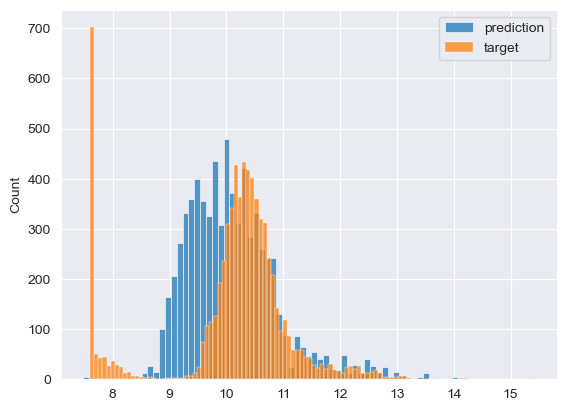

In [115]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='target')
plt.legend()

# Реализация вычисления корня среднеквадратичной ошибки (RMSE - root mean squared error)

In [116]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [117]:
rmse(y_train, y_pred)

0.7554192603920132

# Проверка модели

In [118]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df['age'] = 2024 - df.year
    features.append('age')
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    
    X = df_num.values
    return X

In [119]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation rmse:', rmse(y_val, y_pred))

validation rmse: 0.5172055461058286


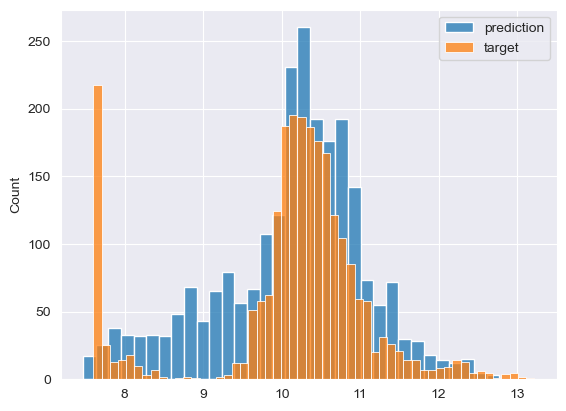

In [120]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_val, label='target')
plt.legend()

# Обработка категориальных переменных

In [121]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    
    df['age'] = 2024 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        value = (df['number_of_doors'] == v).astype(int)
        df[feature] = value
        features.append(feature)
        
    for v in ['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
    
    for v in ['regular_unleaded', 'premium unleaded_(required)',
              'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)']:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
        
    for v in ['automatic', 'manual', 'automated_manual']:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)
    
    for v in ['front_wheel_drive', 'rear_wheel_drive', 
              'all_wheel_drive', 'four_wheel_drive']:
        feature = 'is_driven_wheels_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)

    for v in ['crossover', 'flex_fuel', 'luxury',
              'luxury, performance', 'hatchback']:
        feature = 'is_mc_%s' % v
        df[feature] = (df['market_category'] == v).astype (int)
        features.append(feature)

    for v in ['compact', 'midsize', 'large']:
        feature = 'is_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)

    for v in ['sedan', '4dr_suv', 'coupe', 'convertible',
              '4dr_hatchback']:
        feature = 'is_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)
    
    df_num = df[features]
    df_num = df_num.fillna(0)
    
    X = df_num.values
    return X


In [122]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation rmse:', rmse(y_val, y_pred))

LinAlgError: Singular matrix

# Регуляризация

In [123]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [124]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[6], w[13]))

LinAlgError: Singular matrix

In [125]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r = 0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation rmse:', rmse(y_val, y_pred))

validation rmse: 0.46034586045885123


In [126]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('%6s' %r, rmse(y_val, y_pred))

 1e-06 0.46034481156547036
0.0001 0.4603444022033096
 0.001 0.46034586045885123
  0.01 0.4603605661362202
   0.1 0.46051097140568364
     1 0.4621683306502458
     5 0.46949847144223716
    10 0.4778242870177492


In [127]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.01)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

X_test = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.4603605661362202
test: 0.4572131462800324


# Использование модели

In [128]:
ad = {'city_mpg': 18,
      
'driven_wheels': 'all_wheel_drive',
      
'engine_cylinders': 6.0,
      
'engine_fuel_type': 'regular_unleaded',

'engine_hp': 268.0,

'highway_mpg': 25,

'make': 'toyota',

'market_category': 'crossover,performance',

'model': 'venza',

'number_of_doors': 4.0,

'popularity': 2031,

'transmission_type': 'automatic',

'vehicle_size': 'midsize',

'vehicle_style': 'wagon',

'year': 2013
}

In [129]:
df_test = pd.DataFrame([ad])

X_test = prepare_X(df_test)

In [130]:
y_pred = w_0 + X_test.dot(w)

In [131]:
suggestion = np.expm1(y_pred)

suggestion

array([28239.36657172])